In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Preprocess the data
def preprocess_data(df):
    """
    Preprocesses the dataset by:
    - Normalizing features using MinMaxScaler
    - Splitting data into training and testing sets with stratified sampling

    Input: df (DataFrame)

    Output:
        X_train (DataFrame): Normalized training features
        X_test (DataFrame): Normalized testing features
        y_train (Series): Training labels
        y_test (Series): Testing labels
    """
    # Normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

    # Split features and label
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

In [4]:
# Manually creates the weights and biases for a 3-layer multilayer perceptron (MLP)
def initialize_model(input_dim, hidden_dim, output_dim, device):
    """
    Initializes the weights and biases for a 3-layer MLP (fully connected neural network).

    Layers:
    - Input to Hidden Layer 1 (W1, b1)
    - Hidden Layer 1 to Hidden Layer 2 (W2, b2)
    - Hidden Layer 2 to Output Layer (W3, b3)

    Weights are initialized using a normal distribution scaled by 0.1.

    Input:
        input_dim (int): Number of input features
        hidden_dim (int): Number of neurons in hidden layers
        output_dim (int): Number of output classes
        device (torch.device): Device to store the parameters (CPU or GPU)

    Output:
        list of torch.nn.Parameter: [W1, b1, W2, b2, W3, b3]
    """
    W1 = nn.Parameter(torch.randn(hidden_dim, input_dim, device=device) * 0.1)
    b1 = nn.Parameter(torch.zeros(hidden_dim, device=device))

    W2 = nn.Parameter(torch.randn(hidden_dim, hidden_dim, device=device) * 0.1)
    b2 = nn.Parameter(torch.zeros(hidden_dim, device=device))

    W3 = nn.Parameter(torch.randn(output_dim, hidden_dim, device=device) * 0.1)
    b3 = nn.Parameter(torch.zeros(output_dim, device=device))

    return [W1, b1, W2, b2, W3, b3]

In [5]:
# Perform the forward propagation for the 3-layer multilayer perceptron (MLP)
def forward(x, W1, b1, W2, b2, W3, b3):
    """
    Performs the forward pass through a 3-layer multilayer perceptron (MLP).

    Architecture:
    Input => Linear (W1, b1) => ReLU =>
             Linear (W2, b2) => ReLU =>
             Linear (W3, b3) => Output

    Input:
        x (Tensor): Input features of shape (batch_size, input_dim)
        W1, b1, W2, b2, W3, b3 (Tensor): Model parameters

    Output:
        out (Tensor): Raw output scores (logits) of shape (batch_size, output_dim)
    """
    x = F.relu(x @ W1.t() + b1)
    x = F.relu(x @ W2.t() + b2)
    out = x @ W3.t() + b3
    return out

In [6]:
# Train the model
def train_model(train_loader, parameters, device, epochs=100, lr=0.001):
    """
    Trains the MLP model using the provided training data and parameters.

    Input:
        train_loader (DataLoader): DataLoader containing training data
        parameters (list): List of model parameters [W1, b1, W2, b2, W3, b3]
        device (torch.device): Device to perform training on (CPU or GPU)
        epochs (int): Number of training epochs (default = 100)
        lr (float): Learning rate for the optimizer (default = 0.001)

    Output:
        float: Total training time in seconds
    """
    # Enable gradients for all model parameters
    for param in parameters:
        param.requires_grad_()

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Start timing the training
    start = time.time()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch_x, batch_y in train_loader:
            # Move data to device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = forward(batch_x, *parameters)

            # Compute loss
            loss = criterion(outputs, batch_y)

            # Backward pass and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)

        # Compute average loss
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    end = time.time()  # End timing

    return end - start

In [7]:
# Evaluate the model on the test data
def evaluate_model(test_loader, parameters, device):
    """
    Evaluates the trained model on the test dataset.

    Input:
        test_loader (DataLoader): DataLoader containing test data
        parameters (list): List of model parameters [W1, b1, W2, b2, W3, b3]
        device (torch.device): Device to perform evaluation on (CPU or GPU)

    Output:
        accuracy (float): Test accuracy of the model
        inference_time (float): Time taken to perform inference (in seconds)
        y_true (list): True labels from the test set
        y_pred (list): Predicted labels by the model
    """
    total_correct = 0
    total_samples = 0
    y_true = []
    y_pred = []

    start = time.time()   # Start timing the inference

    with torch.no_grad(): # No gradient needed during evaluation
        for batch_x, batch_y in test_loader:
            # Move data to device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = forward(batch_x, *parameters)

            # Get predicted class labels
            _, preds = torch.max(outputs, 1)

            # Count correct predictions
            total_correct += (preds == batch_y).sum().item()
            total_samples += batch_x.size(0)

             # Store true and predicted labels
            y_true.extend(batch_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    end = time.time() # End timing

    # Compute accuracy and inference time
    accuracy = total_correct / total_samples
    inference_time = end - start

    return accuracy, inference_time, y_true, y_pred

In [8]:
# Prepare PyTorch datasets from the input DataFrame
def prepare_datasets(df):
    """
    Prepares the data for training and testing by:
    - Preprocessing and normalizing the input data
    - Converting features and labels to PyTorch tensors
    - Creating TensorDatasets for training and testing

    Input:
        df (pandas.DataFrame): Raw dataset with features and labels

    Output:
        train_ds (TensorDataset): Training dataset
        test_ds (TensorDataset): Testing dataset
        input_dim (int): Number of input features
        output_dim (int): Number of output classes
    """
    # Preprocess and split the data
    X_train_np, X_test_np, y_train_np, y_test_np = preprocess_data(df)

    # Ensure labels are integers
    y_train_np = y_train_np.astype(int)
    y_test_np = y_test_np.astype(int)

    # Shift labels to start from 0 (if not already)
    label_min = min(y_train_np.min(), y_test_np.min())
    y_train_np -= label_min
    y_test_np -= label_min

    # Convert features and labels to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_np.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_np.values, dtype=torch.long)

    # Create TensorDatasets
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)

    # Get input and output dimensions
    input_dim = X_train_tensor.shape[1]
    output_dim = len(torch.unique(y_train_tensor))

    return train_ds, test_ds, input_dim, output_dim

In [9]:
# Run the full training and evaluation pipeline on the selected device
def run_experiment(device, train_ds, test_ds, input_dim, output_dim):
    """
    Runs the full experiment on the given device:
    - Initializes the model
    - Trains the model
    - Evaluates it on the test set

    Input:
        device (torch.device): Device to run the experiment (CPU or GPU)
        train_ds (TensorDataset): Training dataset
        test_ds (TensorDataset): Testing dataset
        input_dim (int): Number of input features
        output_dim (int): Number of output classes

    Output:
        train_time (float): Time taken to train the model (in seconds)
        inference_time (float): Time taken to evaluate the model (in seconds)
        accuracy (float): Test accuracy
        y_true (list): True test labels
        y_pred (list): Predicted test labels
    """
    print(f"\nRunning on {device}")

    # Set model hyperparameters
    hidden_dim = 64
    batch_size = 64

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Initialize model parameters
    parameters = initialize_model(input_dim, hidden_dim, output_dim, device)

    print("Training model...")
    train_time = train_model(train_loader, parameters, device)

    print("Evaluating model...")
    accuracy, inference_time, y_true, y_pred = evaluate_model(test_loader, parameters, device)

    print(f"\n[RESULTS on {device}]")
    print(f"Training time:   {train_time:.4f} sec")
    print(f"Inference time:  {inference_time:.4f} sec")
    print(f"Test accuracy:   {accuracy:.4f}")

    return train_time, inference_time, accuracy, y_true, y_pred

In [14]:
# Compare CPU vs GPU performance using confusion matrices and classification reports
def evaluate_performance(y_true, y_pred_cpu, y_pred_gpu, cpu_time, gpu_time, cpu_acc, gpu_acc):
    """
    Evaluates and compares model performance between CPU and GPU.

    Input:
        y_true (list or array): Ground truth labels
        y_pred_cpu (list or array): Predictions made by the CPU model
        y_pred_gpu (list or array): Predictions made by the GPU model
        cpu_time (float): Training time on CPU
        gpu_time (float): Training time on GPU
        cpu_acc (float): Test accuracy from CPU
        gpu_acc (float): Test accuracy from GPU

    Output:
        None (displays confusion matrices and prints classification report comparison)
    """
    # Convert to numpy arrays for processing
    y_true = np.array(y_true)
    y_pred_cpu = np.array(y_pred_cpu)
    y_pred_gpu = np.array(y_pred_gpu)

    # Plot confusion matrices for CPU and GPU
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_cpu), annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title("CPU Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    sns.heatmap(confusion_matrix(y_true, y_pred_gpu), annot=True, fmt='d', cmap='Purples', ax=ax[1])
    ax[1].set_title("GPU Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Generate classification reports
    cpu_report = classification_report(y_true, y_pred_cpu, output_dict=True)
    gpu_report = classification_report(y_true, y_pred_gpu, output_dict=True)

    # Convert reports to DataFrames for easier comparison
    cpu_df = pd.DataFrame(cpu_report).transpose()
    gpu_df = pd.DataFrame(gpu_report).transpose()

    # Combine CPU and GPU reports side-by-side
    comparison_df = pd.concat({'CPU': cpu_df, 'GPU': gpu_df}, axis=1)

    print("\n=== Classification Report Comparison (CPU vs GPU) ===\n")
    print(comparison_df.round(3))


Running on cpu
Training model...
Epoch 1/100, Loss: 1.696714
Epoch 2/100, Loss: 1.277246
Epoch 3/100, Loss: 1.225810
Epoch 4/100, Loss: 1.180354
Epoch 5/100, Loss: 1.154257
Epoch 6/100, Loss: 1.145456
Epoch 7/100, Loss: 1.139350
Epoch 8/100, Loss: 1.131949
Epoch 9/100, Loss: 1.127769
Epoch 10/100, Loss: 1.119791
Epoch 11/100, Loss: 1.116721
Epoch 12/100, Loss: 1.114508
Epoch 13/100, Loss: 1.109204
Epoch 14/100, Loss: 1.107576
Epoch 15/100, Loss: 1.103322
Epoch 16/100, Loss: 1.100620
Epoch 17/100, Loss: 1.098356
Epoch 18/100, Loss: 1.097818
Epoch 19/100, Loss: 1.094457
Epoch 20/100, Loss: 1.093089
Epoch 21/100, Loss: 1.090565
Epoch 22/100, Loss: 1.090624
Epoch 23/100, Loss: 1.088105
Epoch 24/100, Loss: 1.086638
Epoch 25/100, Loss: 1.087719
Epoch 26/100, Loss: 1.085950
Epoch 27/100, Loss: 1.084499
Epoch 28/100, Loss: 1.083441
Epoch 29/100, Loss: 1.080975
Epoch 30/100, Loss: 1.083377
Epoch 31/100, Loss: 1.080830
Epoch 32/100, Loss: 1.079302
Epoch 33/100, Loss: 1.079570
Epoch 34/100, Loss

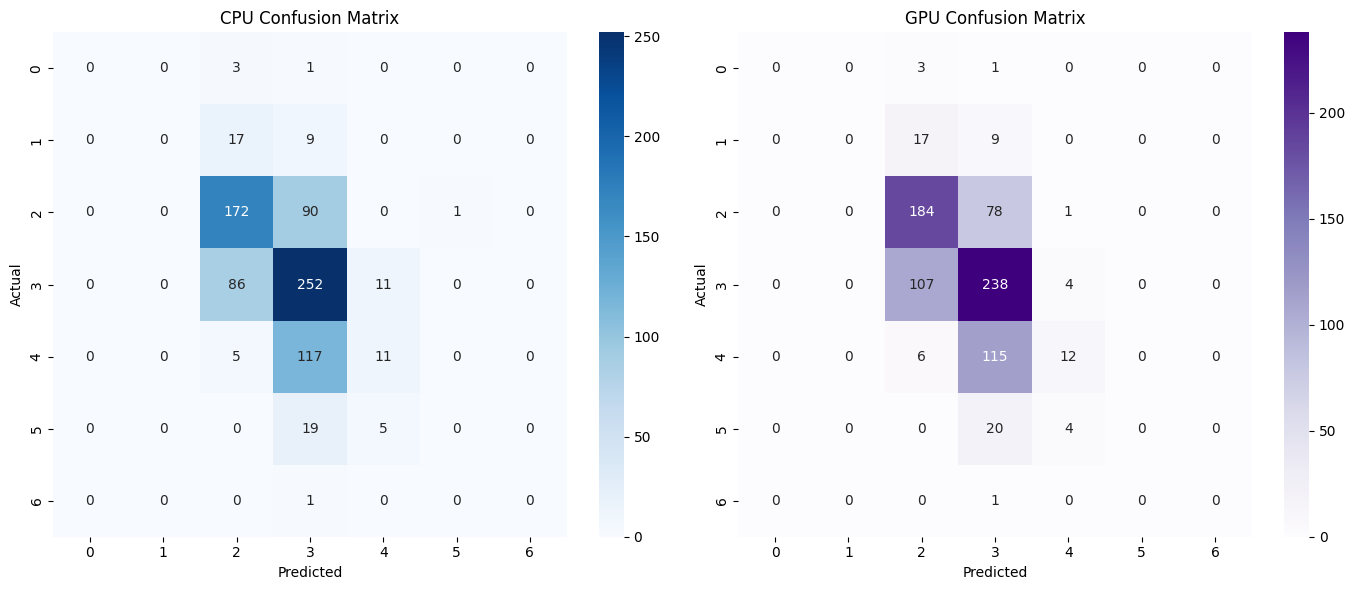


=== Classification Report Comparison (CPU vs GPU) ===

                   CPU                                GPU                  \
             precision recall f1-score  support precision recall f1-score   
0                0.000  0.000    0.000    4.000     0.000  0.000    0.000   
1                0.000  0.000    0.000   26.000     0.000  0.000    0.000   
2                0.608  0.654    0.630  263.000     0.580  0.700    0.634   
3                0.515  0.722    0.601  349.000     0.515  0.682    0.587   
4                0.407  0.083    0.138  133.000     0.571  0.090    0.156   
5                0.000  0.000    0.000   24.000     0.000  0.000    0.000   
6                0.000  0.000    0.000    1.000     0.000  0.000    0.000   
accuracy         0.544  0.544    0.544    0.544     0.542  0.542    0.542   
macro avg        0.219  0.208    0.196  800.000     0.238  0.210    0.197   
weighted avg     0.492  0.544    0.492  800.000     0.511  0.542    0.491   

                   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [15]:
# Main function to run the full CPU vs GPU
def main():
    """
    Loads the dataset, prepares training/testing sets,
    runs training and evaluation on both CPU and GPU,
    and compares performance and accuracy.

    Input: None (file path is hardcoded)
    Output: None (prints results and visualizations)
    """
    # Path to the dataset stored in Google Drive
    file_path = "/content/drive/My Drive/Colab Notebooks/gpu_project/MLoGPU_data3_train.csv"

    # Load the dataset
    df = pd.read_csv(file_path, header=None)

    # Preprocess data and prepare datasets
    train_ds, test_ds, input_dim, output_dim = prepare_datasets(df)

    # CPU
    cpu_train_time, cpu_infer_time, cpu_acc, y_true_cpu, y_pred_cpu = run_experiment(torch.device('cpu'), train_ds, test_ds, input_dim, output_dim)

    # GPU if available
    if torch.cuda.is_available():
        gpu_train_time, gpu_infer_time, gpu_acc, y_true_gpu, y_pred_gpu = run_experiment(torch.device('cuda'), train_ds, test_ds, input_dim, output_dim)

        # Print performance summary
        print("\nSUMMARY:")
        print(f"CPU Training Time:     {cpu_train_time:.4f} sec")
        print(f"GPU Training Time:     {gpu_train_time:.4f} sec")
        print(f"GPU is faster than CPU for training by: {cpu_train_time / gpu_train_time:.2f}x")

        print(f"\nCPU Inference Time:    {cpu_infer_time:.4f} sec")
        print(f"GPU Inference Time:    {gpu_infer_time:.4f} sec")
        print(f"GPU is faster than CPU for inference by: {cpu_infer_time / gpu_infer_time:.2f}x")

        # Accuracy summary
        print(f"\nFinal Test Accuracy (CPU):  {cpu_acc:.4f}")
        print(f"Final Test Accuracy (GPU):  {gpu_acc:.4f}")

        # Compare performance between CPU and GPU
        evaluate_performance(y_true_cpu, y_pred_cpu, y_pred_gpu, cpu_train_time, gpu_train_time, cpu_acc, gpu_acc)
    else:
        print("GPU not available.")

if __name__ == "__main__":
  main()